In [1]:
# Need GPU for skull stripping and faster training
import tensorflow as tf


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True) 

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import convolve

from matplotlib.colors import ListedColormap

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy.ndimage import gaussian_filter
from scipy import ndimage


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import warnings
warnings.filterwarnings('ignore')


from brainextractor import BrainExtractor


from tensorflow.keras.utils import Sequence

from sklearn.metrics import confusion_matrix
from skimage import color
import SimpleITK as sitk

In [3]:
skull_directory = 'UPENN-GBM-SKULL/UPENN-GBM/NIfTI-files/images_structural_unstripped/mri_images/Training/'
brain_directory = 'UPENN-GBM-BRAIN/Training/'
stripped_directory = 'UPENN-GBM-BRAIN-EXTRACT/Training/'
registered_directory = "UPENN-GBM-BRAIN-EXTRACT-coregistered/Training/"

In [4]:
# Make slice visualization what you want
slice_w = 58

# Skull Stripping (Brain Extraction)

In [5]:
# Skull Mri
test_image_flair_unstripped=nib.load(skull_directory + "UPENN-GBM-Training-001/flair.nii").get_fdata()
test_image_t1_unstripped=nib.load(skull_directory + 'UPENN-GBM-Training-001/t1.nii').get_fdata()
test_image_t1gd_unstripped=nib.load(skull_directory+ 'UPENN-GBM-Training-001/t1gd.nii').get_fdata()
test_image_t2_unstripped=nib.load(skull_directory + 'UPENN-GBM-Training-001/t2.nii').get_fdata()
test_mask_unstripped=nib.load(skull_directory + 'UPENN-GBM-Training-001/seg.nii').get_fdata()

Text(0.5, 1.0, 'Mask')

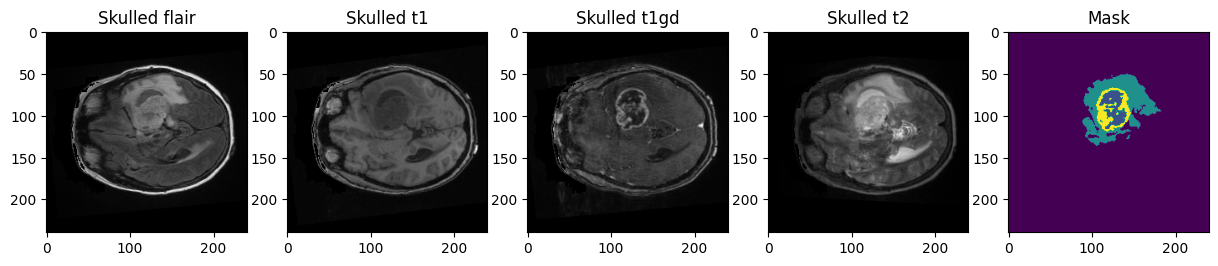

In [6]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (15, 5))

ax1.imshow(test_image_flair_unstripped[:,:,test_image_flair_unstripped.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Skulled flair')
ax2.imshow(test_image_t1_unstripped[:,:,test_image_t1_unstripped.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Skulled t1')
ax3.imshow(test_image_t1gd_unstripped[:,:,test_image_t1gd_unstripped.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Skulled t1gd')
ax4.imshow(test_image_t2_unstripped[:,:,test_image_t2_unstripped.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Skulled t2')
ax5.imshow(test_mask_unstripped[:,:,test_mask_unstripped.shape[0]//2-slice_w])
ax5.set_title('Mask')

In [7]:
# Skull Mri
test_image_flair_brain=nib.load(brain_directory + "UPENN-GBM-Training-001/flair_brain.nii").get_fdata()
test_image_t1_brain=nib.load(brain_directory + 'UPENN-GBM-Training-001/t1_brain.nii').get_fdata()
test_image_t1gd_brain=nib.load(brain_directory+ 'UPENN-GBM-Training-001/t1gd_brain.nii').get_fdata()
test_image_t2_brain=nib.load(brain_directory + 'UPENN-GBM-Training-001/t2_brain.nii').get_fdata()
test_mask_brain=nib.load(brain_directory + 'UPENN-GBM-Training-001/seg_brain.nii').get_fdata()

Text(0.5, 1.0, 'brain')

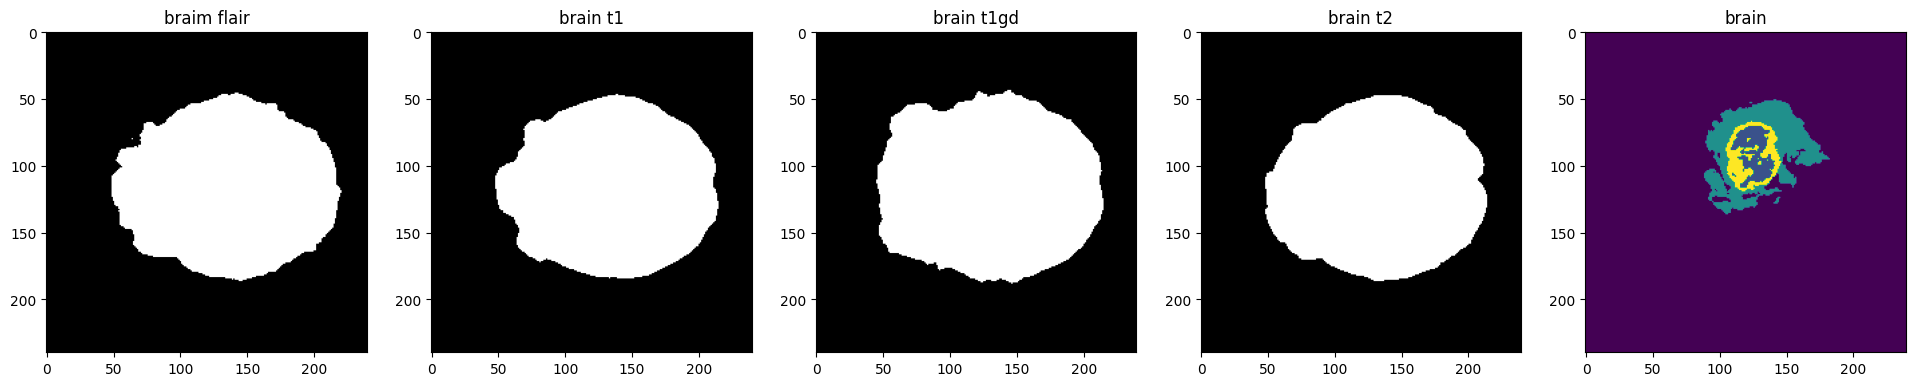

In [8]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (24, 8))

ax1.imshow(test_image_flair_brain[:,:,test_image_flair_brain.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('braim flair')
ax2.imshow(test_image_t1_brain[:,:,test_image_t1_brain.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('brain t1')
ax3.imshow(test_image_t1gd_brain[:,:,test_image_t1gd_brain.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('brain t1gd')
ax4.imshow(test_image_t2_brain[:,:,test_image_t2_brain.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('brain t2')
ax5.imshow(test_mask_brain[:,:,test_mask_brain.shape[0]//2-slice_w])
ax5.set_title('brain')

## Brain Extraction function
FSL implementation of BET

Smith SM. Fast robust automated brain extraction. Hum Brain Mapp.
2002 Nov;17(3):143-55. doi: 10.1002/hbm.10062. PMID: 12391568; PMCID: PMC6871816.

![BET processing flowchart.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6871816/bin/HBM-17-143-g012.jpg)


## Binary Brain Mask Generator 
FSL BET Tool- pip install brainextractor

In [ ]:
def process_modalities(patient_dir, output_patient_dir):
    modalities = ['t1', 'flair', 't1gd', 't2', 'seg']
    for modality in modalities:
        process_modality(patient_dir, output_patient_dir, modality)

def process_modality(patient_dir, output_patient_dir, modality):
    input_file_path = os.path.join(patient_dir, f'{modality}.nii')
    output_file_path = os.path.join(output_patient_dir, f'{modality}_brain.nii')

    try:
        if modality == 'seg' or not os.path.exists(input_file_path) or os.path.exists(output_file_path):
            shutil.copy(input_file_path, output_file_path)
            return

        input_img = nib.load(input_file_path, mmap=False)
        bet = BrainExtractor(img=input_img)
        bet.run()
        bet.save_mask(output_file_path)
    except Exception as e:
        print(f"Error processing {modality} for patient {patient_dir}: {e}")
    finally:
        if 'input_img' in locals():
            del input_img

def process_patient(patient_dir, output_root_dir):
    output_patient_dir = os.path.join(output_root_dir, os.path.basename(patient_dir))
    os.makedirs(output_patient_dir, exist_ok=True)
    process_modalities(patient_dir, output_patient_dir)

root_dir = skull_directory
output_root_dir = brain_directory

batch_size = 1

# Loop through Patient
patient_dirs = [os.path.join(root_dir, patient_id) for patient_id in os.listdir(root_dir)]
for i in range(0, len(patient_dirs), batch_size):
    batch_patient_dirs = patient_dirs[i:i + batch_size]

    # Process each patient 
    for patient_dir in batch_patient_dirs:
        process_patient(patient_dir, output_root_dir)

## Brain Tissue Generator
New method for getting skull stripped brain

In [ ]:
def extract_brain(original_image_path, mask_path, output_path):
    original_img = nib.load(original_image_path, mmap=False)
    mask_img = nib.load(mask_path, mmap=False)
    
    original_data = original_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Apply mask
    brain_data = np.multiply(original_data, mask_data)
    
    # Nifti
    brain_img = nib.Nifti1Image(brain_data, original_img.affine)
    
    nib.save(brain_img, output_path)

def process_patient_extraction(patient_dir_original, patient_dir_brain, output_patient_dir_extracted):
    os.makedirs(output_patient_dir_extracted, exist_ok=True)

    # modalities
    modalities = ['t1', 'flair', 't1gd', 't2', 'seg']
    for modality in modalities:
        original_brain_path = os.path.join(patient_dir_original, f'{modality}.nii')
        binary_mask_path = os.path.join(patient_dir_brain, f'{modality}_brain.nii')
        output_path = os.path.join(output_patient_dir_extracted, f'{modality}_brain_extracted.nii')

        # binary brain mask
        if modality == 'seg':
            # Copy seg
            shutil.copy(original_brain_path, output_path)
        else:
            extract_brain(original_brain_path, binary_mask_path, output_path)

def process_batch_extraction(root_dir_original, root_dir_brain, output_root_dir_extracted, batch_size=1):
    # patients
    patient_dirs = [os.path.join(root_dir_original, patient_id) for patient_id in os.listdir(root_dir_original)]
    for i in range(0, len(patient_dirs), batch_size):
        batch_patient_dirs = patient_dirs[i:i + batch_size]

        # Batch
        for patient_dir in batch_patient_dirs:
            output_patient_dir_extracted = os.path.join(output_root_dir_extracted, os.path.basename(patient_dir))
            process_patient_extraction(patient_dir, os.path.join(root_dir_brain, os.path.basename(patient_dir)), output_patient_dir_extracted)


root_dir_original = skull_directory
root_dir_brain = brain_directory
output_root_dir_extracted = stripped_directory

process_batch_extraction(root_dir_original, root_dir_brain, output_root_dir_extracted, batch_size=1)

# Co-Registeration (not needed for this dataset)

In [ ]:

def co_register_modalities_and_save(root_dir, output_dir):
   
    patient_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

 
    os.makedirs(output_dir, exist_ok=True)

    for patient_dir in patient_dirs:
        print(f"Processing patient ID: {patient_dir}")

     
        modalities = ['t1', 't2', 't1gd', 'flair', 'seg']
        image_paths = {mod: os.path.join(root_dir, patient_dir, f"{mod}_brain_extracted.nii") for mod in modalities}

    
        reference_image = sitk.ReadImage(image_paths['t1'])

        # Loop through modalities and register  
        registered_modalities = {'t1': reference_image}
        for mod in modalities:
            if mod != 't1':  # Skip T1
                moving_image = sitk.ReadImage(image_paths[mod])

                # Registration
                registration_method = sitk.ImageRegistrationMethod()
                registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
                registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
                registration_method.SetMetricSamplingPercentage(0.01)
                registration_method.SetInterpolator(sitk.sitkLinear)
                registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, estimateLearningRate=registration_method.EachIteration)
                registration_method.SetOptimizerScalesFromIndexShift()
                final_transform = registration_method.Execute(sitk.Cast(reference_image, sitk.sitkFloat32),
                                                              sitk.Cast(moving_image, sitk.sitkFloat32))

                # Apply the transformation to the moving image
                registered_image = sitk.Resample(moving_image, reference_image, final_transform, sitk.sitkLinear, 0.0,
                                                 moving_image.GetPixelID())

                
                registered_modalities[mod] = registered_image
                

       
        output_patient_dir = os.path.join(output_dir, patient_dir)
        os.makedirs(output_patient_dir, exist_ok=True)
        for mod, image in registered_modalities.items():
            sitk.WriteImage(image, os.path.join(output_patient_dir, f"{mod}_brain_extracted.nii"))

    


root_directory = "UPENN-GBM-BRAIN-EXTRACT/Training/"
output_root_directory = "UPENN-GBM-BRAIN-EXTRACT-coregistered/Training/"
co_register_modalities_and_save(root_directory, output_root_directory)


# Dataset path

In [9]:
# MAke what you want to visualize
slice_w = 58

In [10]:
Train_path = registered_directory

In [11]:
test_image_flair_stripped=nib.load(Train_path + 'UPENN-GBM-Training-001/flair_brain_extracted.nii').get_fdata()
test_image_t1_stripped=nib.load(Train_path + 'UPENN-GBM-Training-001/t1_brain_extracted.nii').get_fdata()
test_image_t1gd_stripped=nib.load(Train_path + 'UPENN-GBM-Training-001/t1gd_brain_extracted.nii').get_fdata()
test_image_t2_stripped=nib.load(Train_path + 'UPENN-GBM-Training-001/t2_brain_extracted.nii').get_fdata()
test_mask_stripped=nib.load(Train_path + 'UPENN-GBM-Training-001/seg_brain_extracted.nii').get_fdata()

Text(0.5, 1.0, 'registered Mask')

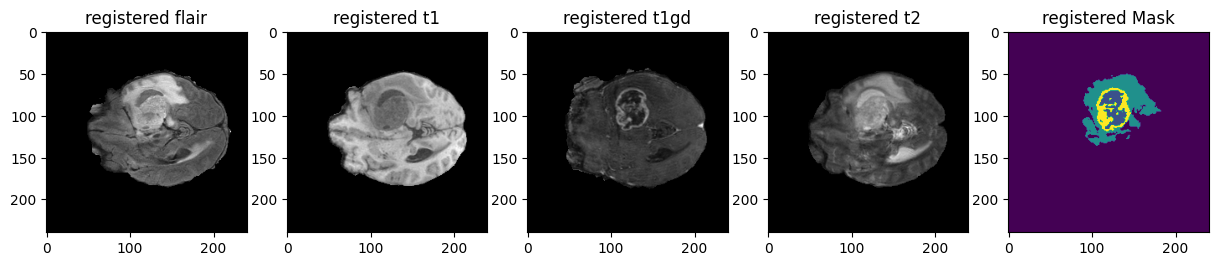

In [12]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (15, 5))
ax1.imshow(test_image_flair_stripped[:,:,test_image_flair_stripped.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('registered flair')
ax2.imshow(test_image_t1_stripped[:,:,test_image_t1_stripped.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('registered t1')
ax3.imshow(test_image_t1gd_stripped[:,:,test_image_t1gd_stripped.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('registered t1gd')
ax4.imshow(test_image_t2_stripped[:,:,test_image_t2_stripped.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('registered t2')
ax5.imshow(test_mask_stripped[:,:,test_mask_stripped.shape[0]//2-slice_w])
ax5.set_title('registered Mask')

In [13]:
Training_path = stripped_directory
# Or whatever the segmentation directory is

In [14]:
test_image_flair_stripped=nib.load(Training_path + 'UPENN-GBM-Training-001/flair_brain_extracted.nii').get_fdata()
test_image_t1_stripped=nib.load(Training_path + 'UPENN-GBM-Training-001/t1_brain_extracted.nii').get_fdata()
test_image_t1gd_stripped=nib.load(Training_path + 'UPENN-GBM-Training-001/t1gd_brain_extracted.nii').get_fdata()
test_image_t2_stripped=nib.load(Training_path + 'UPENN-GBM-Training-001/t2_brain_extracted.nii').get_fdata()
test_mask_stripped=nib.load(Training_path + 'UPENN-GBM-Training-001/seg_brain_extracted.nii').get_fdata()

Text(0.5, 1.0, 'Mask')

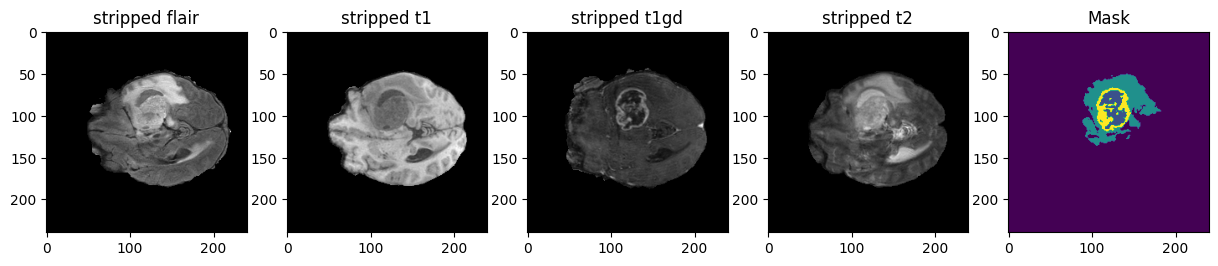

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (15, 5))
ax1.imshow(test_image_flair_stripped[:,:,test_image_flair_stripped.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('stripped flair')
ax2.imshow(test_image_t1_stripped[:,:,test_image_t1_stripped.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('stripped t1')
ax3.imshow(test_image_t1gd_stripped[:,:,test_image_t1gd_stripped.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('stripped t1gd')
ax4.imshow(test_image_t2_stripped[:,:,test_image_t2_stripped.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('stripped t2')
ax5.imshow(test_mask_stripped[:,:,test_mask_stripped.shape[0]//2-slice_w])
ax5.set_title('Mask')

In [16]:

seg_path = os.path.join(Training_path, 'UPENN-GBM-Training-001', 'seg_brain_extracted.nii')

# Load the NIfTI file
seg_nifti = nib.load(seg_path)

# Get the shape of the data array
seg_shape = seg_nifti.get_fdata().shape

print("Shape of segmentation data:", seg_shape)

Shape of segmentation data: (240, 240, 155)


## 3D Input

In [17]:
# this is the volume we will put in the 3d unet
temp_combined_images = np.stack([test_image_flair_stripped, test_image_t1gd_stripped, test_image_t2_stripped], axis=3)
print(temp_combined_images.shape)


(240, 240, 155, 3)


## Segment Types

In [18]:
# DEFINE seg-areas  
num_classes = {
    0 : 'not tumor',   
    1 : 'necrotic/core', # or Non-enhancing tumor
    2 : 'edema',  
    3 : 'enhancing' # Aka 4
}
 



# Tumor Visuals

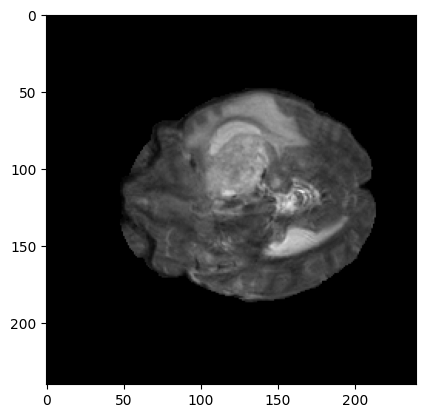

In [19]:
## Volume stack shape (240, 240, 155, 3)
plt.imshow(temp_combined_images[:,:,test_image_t2_stripped.shape[0]//2-slice_w,2], cmap = 'gray')

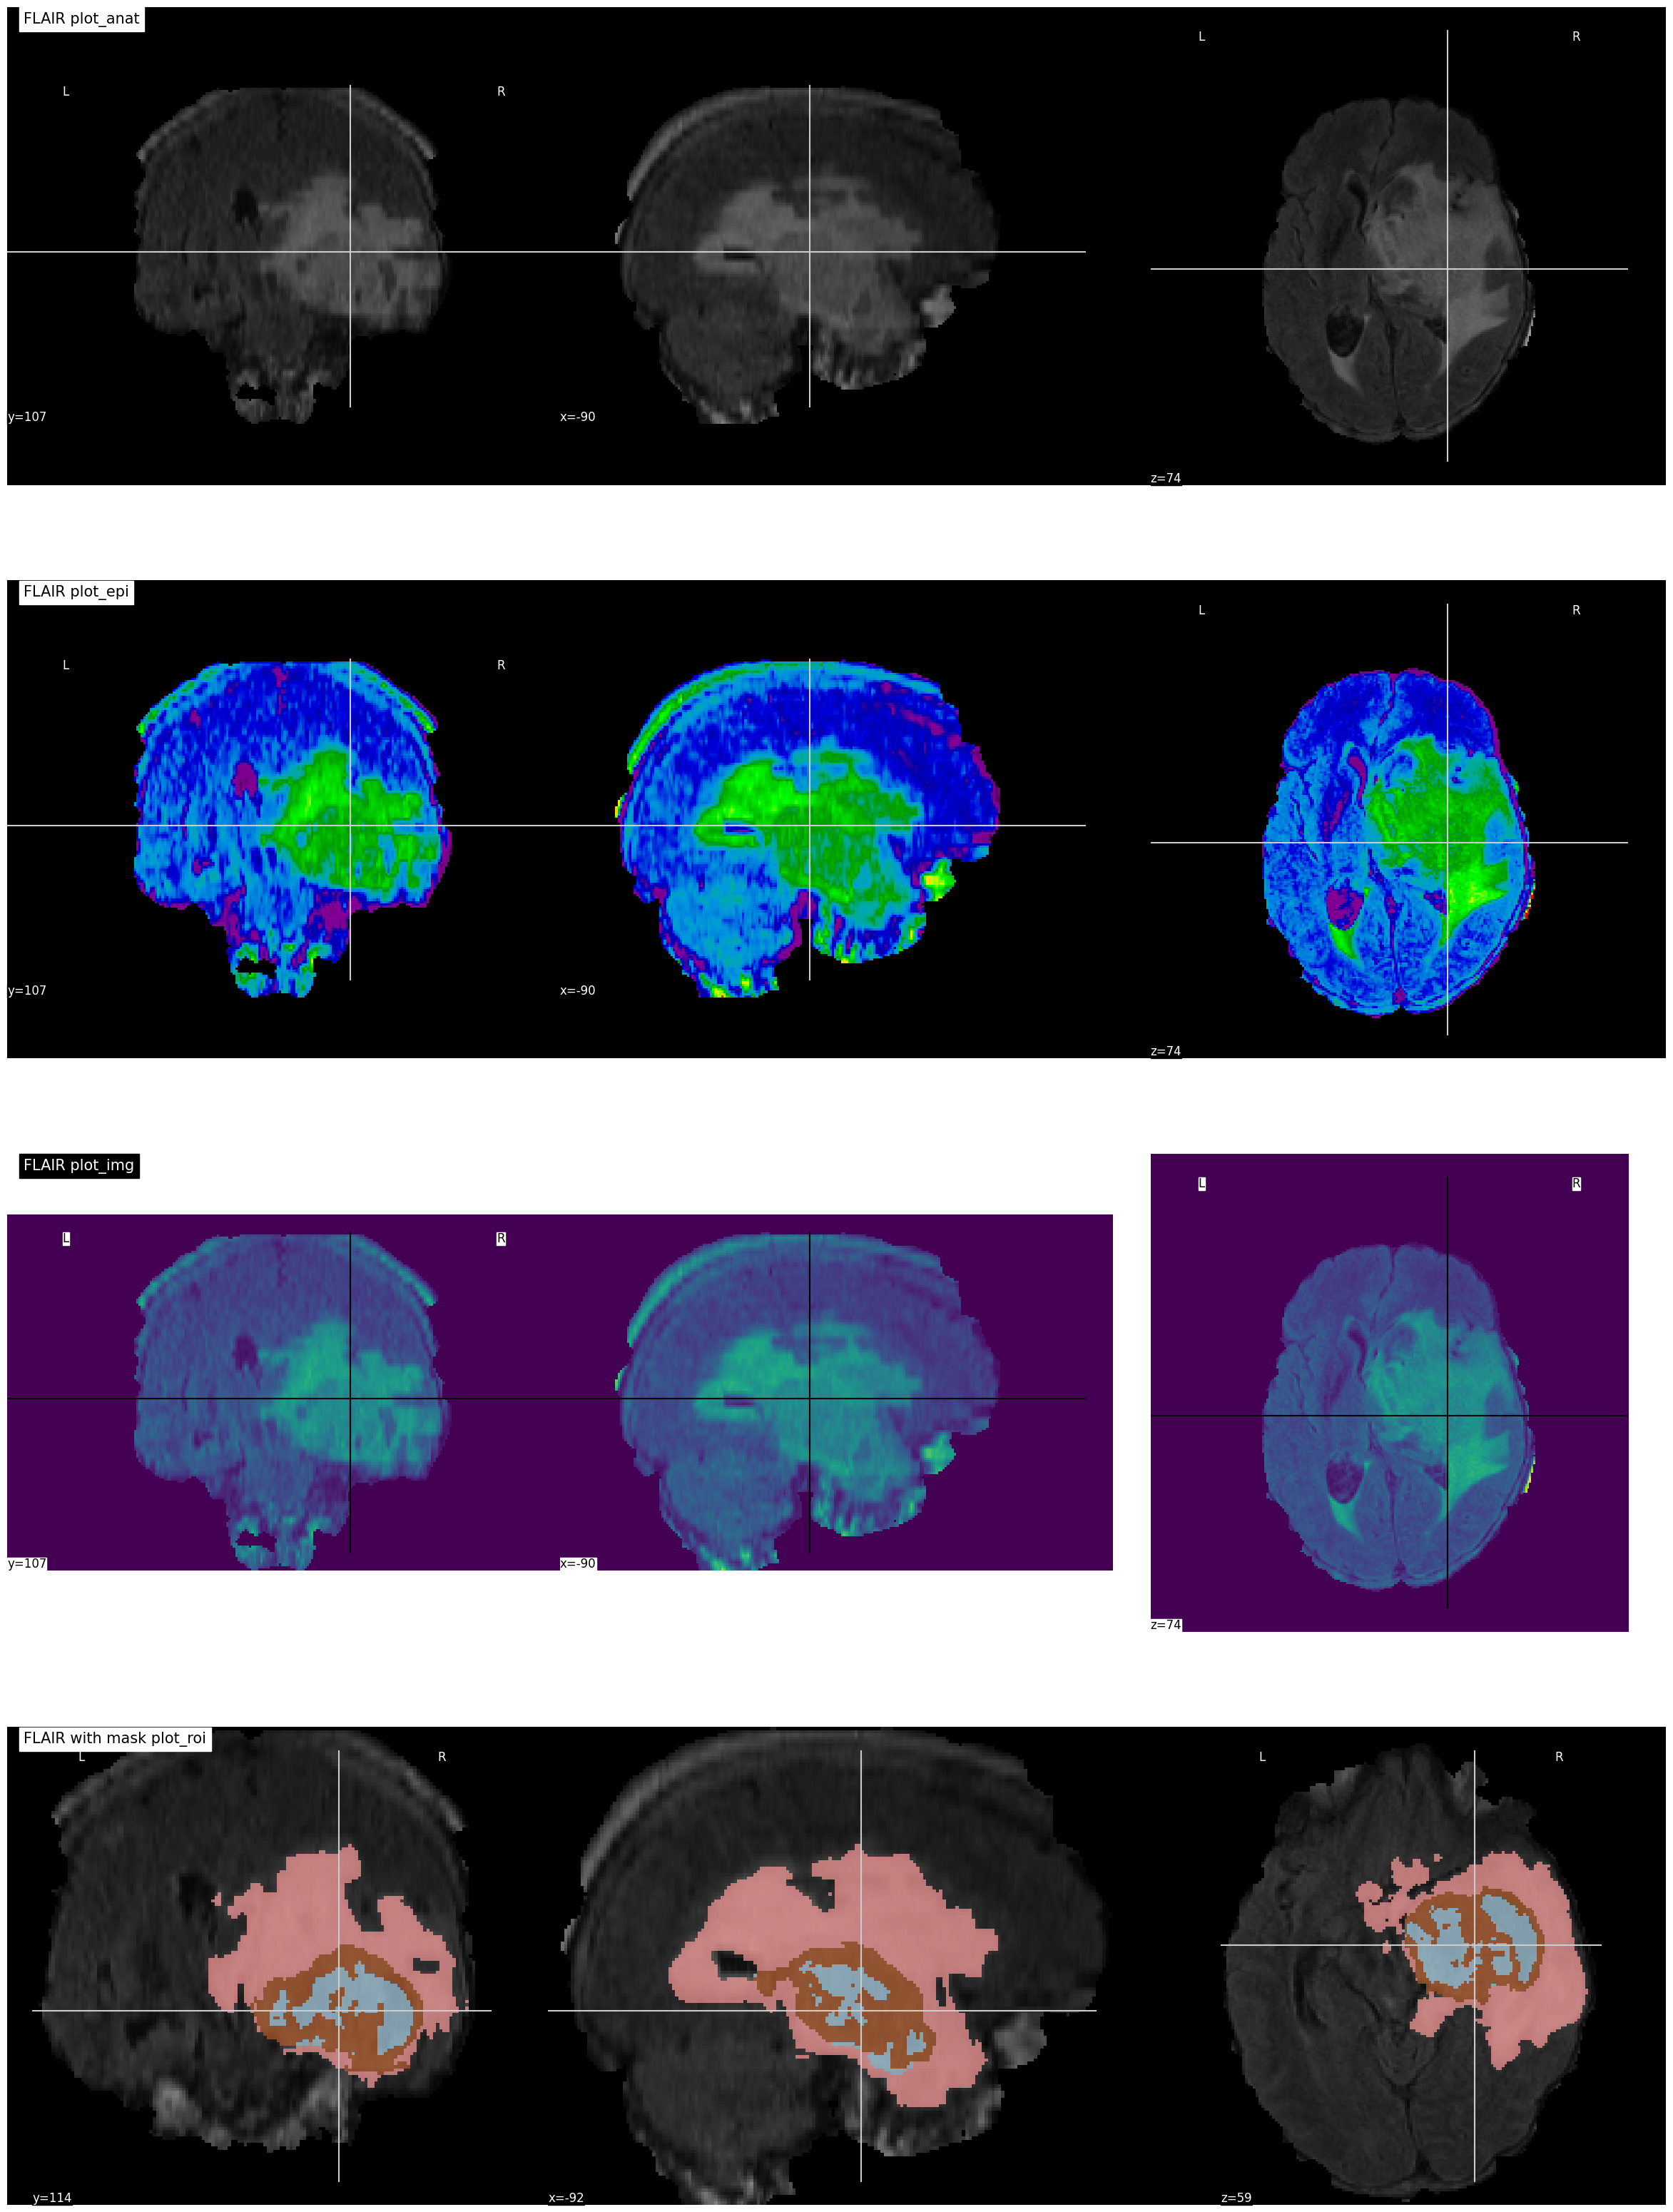

In [20]:
niimg = nl.image.load_img(Training_path + 'UPENN-GBM-Training-001/flair_brain_extracted.nii')
nimask = nl.image.load_img(Training_path + 'UPENN-GBM-Training-001/seg_brain_extracted.nii')

fig, axes = plt.subplots(nrows=4, figsize = (30, 40))

nlplt.plot_anat(niimg,
                title = 'FLAIR plot_anat',
                axes = axes[0])

nlplt.plot_epi(niimg,
                title = 'FLAIR plot_epi',
                axes = axes[1])

nlplt.plot_img(niimg,
               title = 'FLAIR plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask,
               title = 'FLAIR with mask plot_roi',
               bg_img = niimg,
               axes = axes[3], cmap = 'Paired')

plt.show()

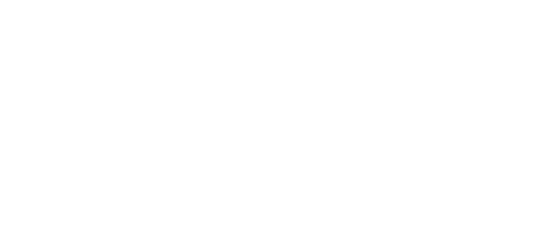

In [21]:
from IPython.display import Image
import imageio
from keras.utils import to_categorical
image_nifty_file = Training_path + 'UPENN-GBM-Training-001/flair_brain_extracted.nii'
image = np.array(nib.load(image_nifty_file).get_fdata())

label_nifty_file = Training_path + 'UPENN-GBM-Training-001/seg_brain_extracted.nii'
label = np.array(nib.load(label_nifty_file).get_fdata())

is_categorical=False
if not is_categorical:
    label_cat = to_categorical(label, num_classes=0).astype(np.uint8)
label_cat.shape

image_norm = cv2.normalize(image[:, :, :], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
image_norm.shape
labeled_image = np.zeros_like(label_cat[:, :, :, 1:])

# remove tumor part from image
labeled_image[:, :, :, 0] = image_norm * (label_cat[:, :, :, 0])
labeled_image[:, :, :, 1] = image_norm * (label_cat[:, :, :, 0])
labeled_image[:, :, :, 2] = image_norm * (label_cat[:, :, :, 0])

# color labels
labeled_image += label_cat[:, :, :, 1:] * 255

labeled_image.shape

data_all = []
data_all.append(labeled_image)
np.array(data_all).shape

def visualize_data_gif(data_):
    images = []
    for i in range(data_.shape[0]):
        x = data_[min(i, data_.shape[0] - 1), :, :]
        y = data_[:, min(i, data_.shape[1] - 1), :]
        z = data_[:, :, min(i, data_.shape[2] - 1)]
        img = np.concatenate((x, y, z), axis=1)
        images.append(img)
    imageio.mimsave("./gif.gif", images, duration=0.01)
    return Image(filename="./gif.gif", format='png')

visualize_data_gif(labeled_image)

# Preprocess

In [22]:
def resize_image(image, target_shape):
    resized_image = resize(image.astype(np.float32), target_shape[:-1], mode='constant', anti_aliasing=True)
    return resized_image

In [23]:
def resize_seg(seg, target_shape):
    # Resize seg nearest-neighbor interpolation
    resized_seg = resize(seg.astype(np.float32), target_shape[:-1], mode='constant', anti_aliasing=False, order=0)

    # Round values to the nearest integer
    resized_seg = np.round(resized_seg).astype(np.uint8)

    return resized_seg

In [24]:
def normalize_image(image):
    return (image - np.mean(image)) / np.std(image)

In [25]:

def load_and_preprocess_data(root_dir, image_size=128, train_size=0.7, val_size=0.2, test_size=0.1, random_seed=42):
    # Initialize
    data = []
    labels = []

    
    for patient_folder in os.listdir(root_dir):
        patient_path = os.path.join(root_dir, patient_folder)
        flair_path = os.path.join(patient_path, 'flair_brain_extracted.nii')
        t1_path = os.path.join(patient_path, 't1_brain_extracted.nii')
        t1gd_path = os.path.join(patient_path, 't1gd_brain_extracted.nii')
        t2_path = os.path.join(patient_path, 't2_brain_extracted.nii')
        seg_path = os.path.join(patient_path, 'seg_brain_extracted.nii')

        # nifti
        flair = nib.load(flair_path).get_fdata()
        t1 = nib.load(t1_path).get_fdata()
        t1gd = nib.load(t1gd_path).get_fdata()
        t2 = nib.load(t2_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()

        
        flair = normalize_image(flair)
        t1 = normalize_image(t1)
        t1gd = normalize_image(t1gd)
        t2 = normalize_image(t2)

        # 3d vol
        stacked_image = np.stack([t2, t1gd, flair], axis=-1)

        # Resize 
        stacked_image = resize_image(stacked_image, (image_size, image_size, image_size, 3))


        
        # seg labels
        seg = seg.astype(np.uint8)
        seg[seg == 4] = 3
        seg = resize_seg(seg, (image_size, image_size, image_size, 4))
        seg = to_categorical(seg, num_classes=4)
        


       # data and labels to lists
        data.append(stacked_image)
        labels.append(seg)

    X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=1-train_size, random_state=random_seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(1-train_size), random_state=random_seed)

    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test)



root_dir = Training_path
image_size = 128

X_train, y_train, X_val, y_val, X_test, y_test = load_and_preprocess_data(root_dir, image_size)




In [26]:

num_train_patients = len(X_train)
num_val_patients = len(X_val)
num_test_patients = len(X_test)

print(f"Number of patients in the training set: {num_train_patients}")
print(f"Number of patients in the validation set: {num_val_patients}")
print(f"Number of patients in the test set: {num_test_patients}")


Number of patients in the training set: 102
Number of patients in the validation set: 30
Number of patients in the test set: 15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


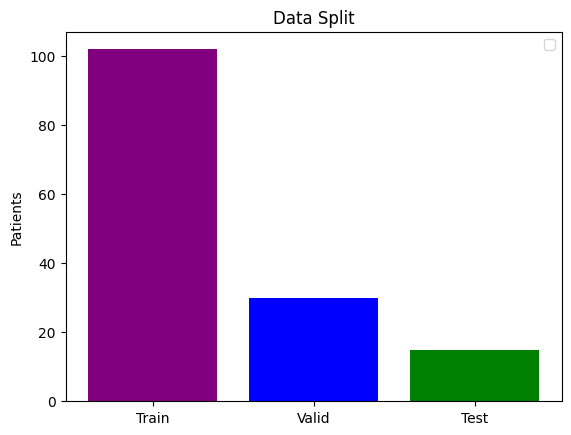

In [27]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(X_train), len(X_val), len(X_test)], align='center',color=[ 'purple','blue', 'green'])
    plt.legend()

    plt.ylabel('Patients')
    plt.title('Data Split')
    plt.savefig('GBMFINAL.png')
    plt.show()

showDataLayout()

In [28]:

# Created because not enough somputer strength
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_X = self.X[start:end]
        batch_y = self.y[start:end]
        return np.array(batch_X), np.array(batch_y)


train_generator = DataGenerator(X_train, y_train, batch_size=1)
val_generator = DataGenerator(X_val, y_val, batch_size=1)
test_generator = DataGenerator(X_test, y_test, batch_size=1)

# Loss
Dice similarity coefficient is a spatial overlap index and a reproducibility validation metric. It was also called the proportion of specific agreement by Fleiss (14). The value of a DSC ranges from 0, indicating no spatial overlap between two sets of binary segmentation results, to 1, indicating complete overlap.

![dice loss](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

Zou KH, Warfield SK, Bharatha A, Tempany CM, Kaus MR, Haker SJ, Wells WM 3rd, Jolesz FA, Kikinis R. Statistical validation of image segmentation quality based on a spatial overlap index. Acad Radiol. 2004 Feb;11(2):178-89. doi: 10.1016/s1076-6332(03)00671-8. PMID: 14974593; PMCID: PMC1415224.

In [29]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    axis = (0, 1, 2, 3)

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true * y_true, axis=axis) + K.sum(y_pred * y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator) / (dice_denominator))

def dice_coef_loss(y_true, y_pred, epsilon=0.00001):
    return 1 - dice_coef(y_true, y_pred, epsilon=epsilon)






def dice_coef_class(y_true, y_pred, class_index, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, :, class_index] * y_pred[:, :, :, :, class_index]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, :, class_index])) + K.sum(K.square(y_pred[:, :, :, class_index])) + epsilon)

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    return dice_coef_class(y_true, y_pred, class_index=1, epsilon=epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    return dice_coef_class(y_true, y_pred, class_index=2, epsilon=epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    return dice_coef_class(y_true, y_pred, class_index=3, epsilon=epsilon)


In [30]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (actual_positives + K.epsilon())
    return sensitivity

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    actual_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (actual_negatives + K.epsilon())
    return specificity

# 3D U-Net
The u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin (See also our annoucement).


![official definiton](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.

Ronneberger, Olaf, et al. “U-Net: Convolutional Networks for Biomedical Image Segmentation.” Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015, edited by Nassir Navab et al., Springer International Publishing, 2015, pp. 234–41. Springer Link, https://doi.org/10.1007/978-3-319-24574-4_28.


In [31]:
def build_unet(inputs, ker_init):

    #Encoder path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c5)
    
    #Decoder path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c9)
     
    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model
    
image_size = 128

input_layer = Input((image_size, image_size, image_size, 3))
model = build_unet(input_layer, 'he_normal')


In [32]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001) , loss='categorical_crossentropy',
              metrics=['accuracy', precision, specificity, sensitivity, 
                       tf.keras.metrics.MeanIoU(num_classes = 4, name='mean_io_u'), 
                       dice_coef, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

In [33]:
input_shape = model.input_shape
print("Model's input shape:", input_shape)

Model's input shape: (None, 128, 128, 128, 3)


In [34]:
for layer in model.layers:
    print(f"{layer.name}")

input_1
conv3d
dropout
conv3d_1
max_pooling3d
conv3d_2
dropout_1
conv3d_3
max_pooling3d_1
conv3d_4
dropout_2
conv3d_5
max_pooling3d_2
conv3d_6
dropout_3
conv3d_7
max_pooling3d_3
conv3d_8
dropout_4
conv3d_9
conv3d_transpose
concatenate
conv3d_10
dropout_5
conv3d_11
conv3d_transpose_1
concatenate_1
conv3d_12
dropout_6
conv3d_13
conv3d_transpose_2
concatenate_2
conv3d_14
dropout_7
conv3d_15
conv3d_transpose_3
concatenate_3
conv3d_16
dropout_8
conv3d_17
conv3d_18


In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

# Training

In [30]:
filepath="GBM-V5dalal-improvement-{epoch:02d}-{val_mean_io_u:.3f}.hdf5" 

checkpoint = ModelCheckpoint(filepath, monitor='val_mean_io_u', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=200, verbose=1, restore_best_weights=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100, min_lr=1e-7, verbose=1)

csv_logger = CSVLogger('GBM_UNET_V5dalal.log')


In [31]:
K.clear_session()

In [32]:
epochs = 1000
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr, early_stop, csv_logger]
)


Epoch 1/1000
102/102 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9746 - precision: 0.9845 - specificity: 0.9968 - sensitivity: 0.9638 - mean_io_u: 0.8042 - dice_coef: 0.3048 - dice_coef_necrotic: 0.0130 - dice_coef_edema: 0.0680 - dice_coef_enhancing: 0.0083
Epoch 1: val_mean_io_u improved from -inf to 0.85351, saving model to GBM-V5dalal-improvement-01-0.854.hdf5
102/102 [==============================] - 51s 356ms/step - loss: 0.0986 - accuracy: 0.9746 - precision: 0.9845 - specificity: 0.9968 - sensitivity: 0.9638 - mean_io_u: 0.8042 - dice_coef: 0.3048 - dice_coef_necrotic: 0.0130 - dice_coef_edema: 0.0680 - dice_coef_enhancing: 0.0083 - val_loss: 0.0430 - val_accuracy: 0.9915 - val_precision: 0.9972 - val_specificity: 0.9991 - val_sensitivity: 0.9798 - val_mean_io_u: 0.8535 - val_dice_coef: 0.3935 - val_dice_coef_necrotic: 0.0433 - val_dice_coef_edema: 0.1436 - val_dice_coef_enhancing: 0.0437 - lr: 0.0010
Epoch 2/1000
102/102 [==========================

In [33]:
model.save('GBM_UNET_V5dalal_model.h5')

# Graphing

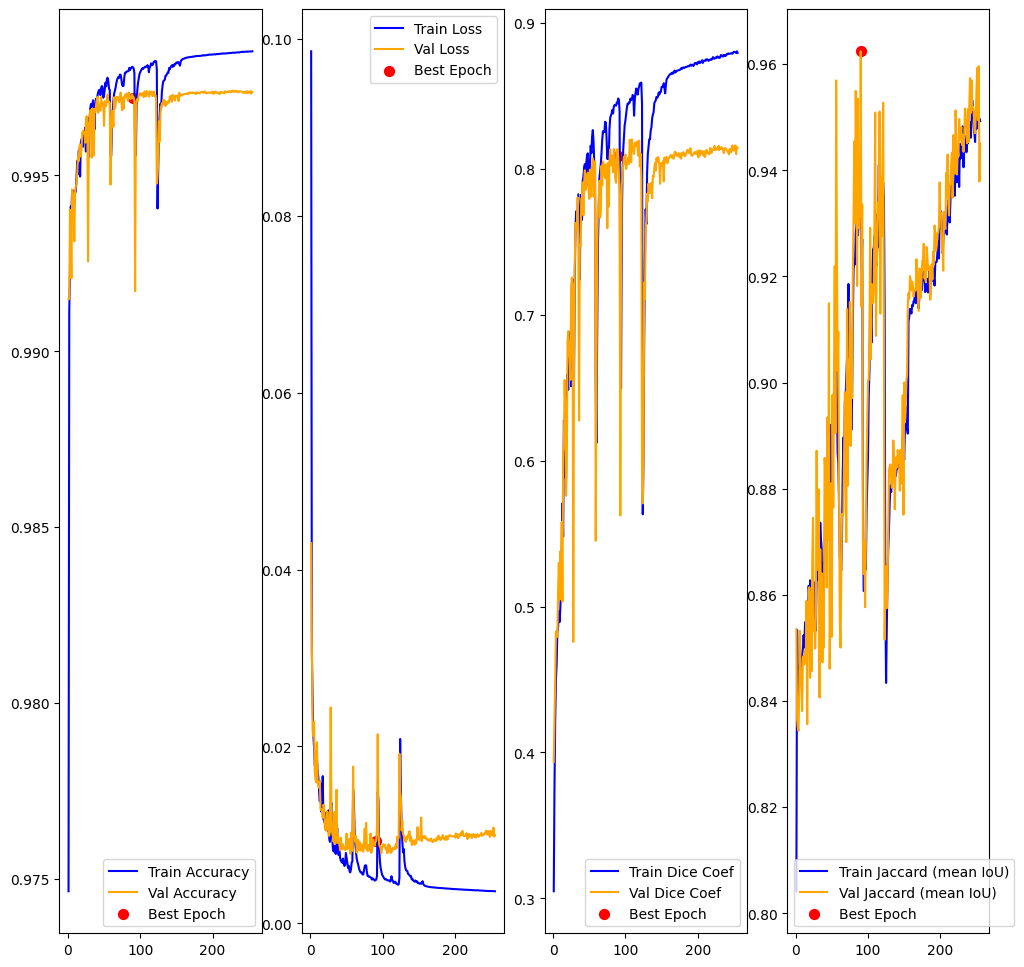

In [36]:

model = tf.keras.models.load_model('GBM_UNET_V5dalal_model.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity
                                                  }, compile=False)

history = pd.read_csv('GBM_UNET_V5dalal.log', sep=',', engine='python')


epoch = range(1, len(history['accuracy']) + 1)


f, ax = plt.subplots(1, 4, figsize=(12,12))

# Plot Train and Validation Accuracy
ax[0].plot(epoch, history['accuracy'], 'b', label='Train Accuracy')
ax[0].plot(epoch, history['val_accuracy'], 'orange', label='Val Accuracy')

# Mark epoch 90 with a red dot on validation metrics
ax[0].scatter(90, history['val_accuracy'].iloc[89], color='red', s=50, label='Best Epoch')

ax[0].legend()

# Plot Train and Validation Loss
ax[1].plot(epoch, history['loss'], 'b', label='Train Loss')
ax[1].plot(epoch, history['val_loss'], 'orange', label='Val Loss')


ax[1].scatter(90, history['val_loss'].iloc[89], color='red', s=50, label='Best Epoch')

ax[1].legend()

# Plot Train and Validation Dice Coef
ax[2].plot(epoch, history['dice_coef'], 'b', label='Train Dice Coef')
ax[2].plot(epoch, history['val_dice_coef'], 'orange', label='Val Dice Coef')


ax[2].scatter(90, history['val_dice_coef'].iloc[89], color='red', s=50, label='Best Epoch')

ax[2].legend()

# Plot Train and Validation Mean IOU
ax[3].plot(epoch, history['mean_io_u'], 'b', label='Train Jaccard (mean IoU)')
ax[3].plot(epoch, history['val_mean_io_u'], 'orange', label='Val Jaccard (mean IoU)')


ax[3].scatter(90, history['val_mean_io_u'].iloc[89], color='red', s=50, label='Best Epoch')

ax[3].legend()


plt.savefig('training_GBM_UNET_V5dalal.png')
plt.show()

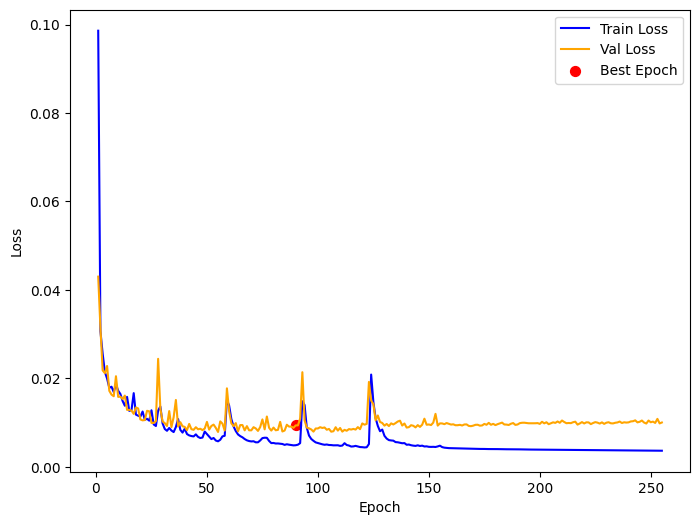

In [37]:

epoch = range(1, len(history['loss']) + 1)


plt.figure(figsize=(8, 6))

# Plot Train and Validation Loss
plt.plot(epoch, history['loss'], 'b', label='Train Loss')
plt.plot(epoch, history['val_loss'], 'orange', label='Val Loss')


plt.scatter(90, history['val_loss'].iloc[89], color='red', s=50, label='Best Epoch')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.savefig('loss_GBM_UNET_V5dalal.png')
plt.show()

# Evaluate Test Data

In [38]:

csv_logger = CSVLogger('./evaluation_GBM_UNet_V5dalal.log')
model = tf.keras.models.load_model('GBM-V5dalal-improvement-90-0.962.hdf5', 
                                   custom_objects={
                                       'accuracy': tf.keras.metrics.MeanIoU(num_classes=4),
                                       'dice_coef': dice_coef,
                                       'dice_coef_loss': dice_coef_loss,
                                       'precision': precision,
                                       'sensitivity': sensitivity,
                                       'specificity': specificity,
                                       'dice_coef_necrotic': dice_coef_necrotic,
                                       'dice_coef_edema': dice_coef_edema,
                                       'dice_coef_enhancing': dice_coef_enhancing
                                   },
                                   compile=True)

learning_rate = model.optimizer.lr.numpy()
print("Learning rate:", learning_rate)
# Evaluate the model on the test data 
print("Evaluate on test data")
results = model.evaluate(test_generator, callbacks= [csv_logger])
print("test loss, test acc:", results)

Learning rate: 0.001
Evaluate on test data
15/15 [==============================] - 10s 172ms/step - loss: 0.0083 - accuracy: 0.9972 - precision: 0.9974 - specificity: 0.9991 - sensitivity: 0.9971 - mean_io_u: 0.9636 - dice_coef: 0.8173 - dice_coef_necrotic: 0.1612 - dice_coef_edema: 0.6215 - dice_coef_enhancing: 0.3053
test loss, test acc: [0.00829301681369543, 0.9971810579299927, 0.9973636865615845, 0.9991214871406555, 0.9970568418502808, 0.9636334776878357, 0.8172739744186401, 0.16115696728229523, 0.6215088963508606, 0.30527880787849426]


15/15 [==============================] - 2s 148ms/step


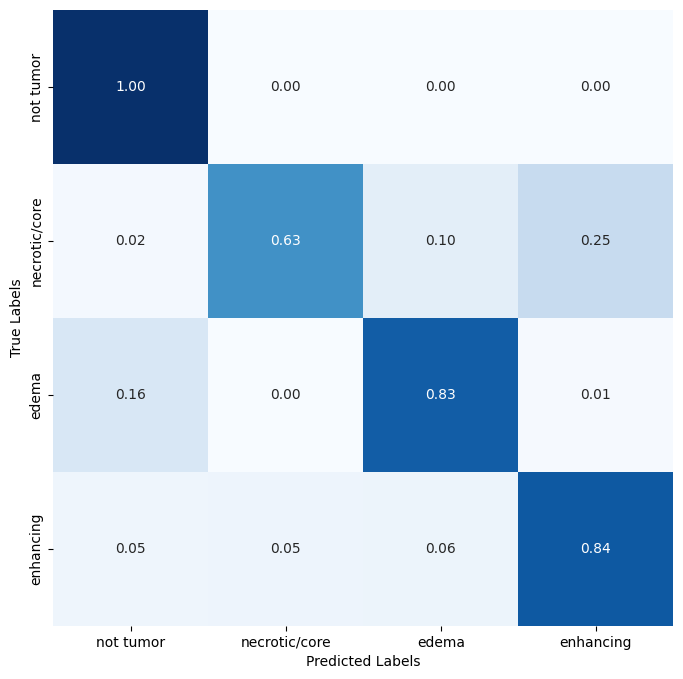

In [39]:
y_test_pred = model.predict(test_generator)


y_test_true_labels = np.argmax(y_test, axis=-1)


y_test_pred_labels = np.argmax(y_test_pred, axis=-1)




conf_matrix_test = confusion_matrix(y_test_true_labels.flatten(), y_test_pred_labels.flatten())

def plot_confusion_matrix(matrix, class_names):
    plt.figure(figsize=(8, 8))
    
    # Normalize the confusion matrix for better visualization
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    
    
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    
 
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig('confMatrix')
    plt.show()


class_names = ['not tumor', 'necrotic/core', 'edema', 'enhancing']


plot_confusion_matrix(conf_matrix_test, class_names)


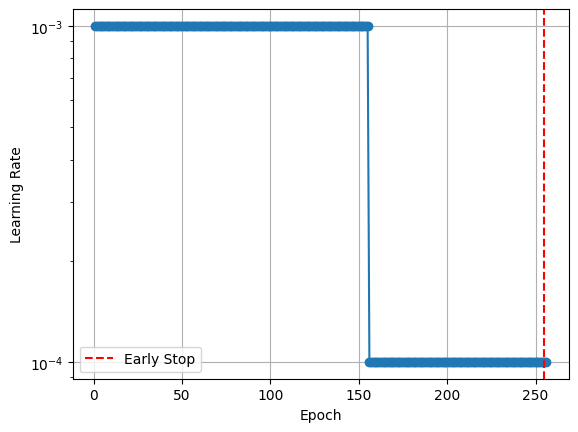

In [40]:
# Manually Graphed callbacks
epochs = 255
initial_lr = 0.001
lr_schedule = [
    (155, 1e-4),
]

# learning rates
learning_rates = [initial_lr]

# Generate
for epoch in range(1, epochs + 1):
    for change_epoch, new_lr in lr_schedule:
        if epoch == change_epoch:
            initial_lr = new_lr
    learning_rates.append(initial_lr)


plt.plot(range(1, epochs + 2), learning_rates, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log') 


plt.axvline(x=255, color='red', linestyle='--', label='Early Stop')

plt.grid(True)
plt.legend()
plt.savefig('LR-Schedule')
plt.show()

# Prediction Visualization

In [41]:
predictions = model.predict(test_generator)


# Convert class probabilites into actual segmentation mask
resized_masks = np.argmax(predictions, axis = -1)


15/15 [==============================] - 2s 167ms/step


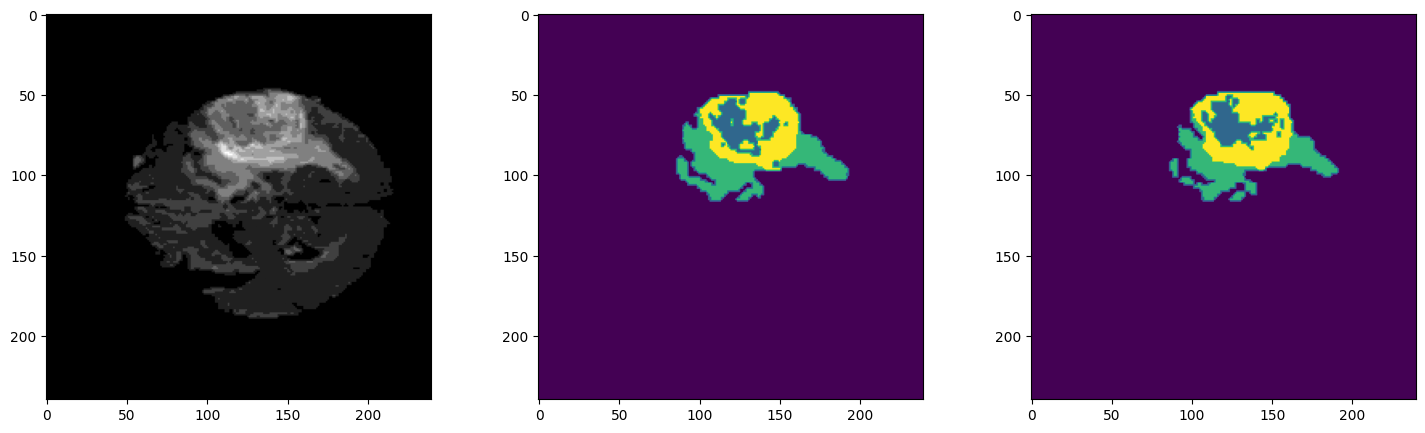

In [42]:
example_index = 12
slice_index = 56

# Get Flair Image
input_flair_image = X_test[example_index, :, :, slice_index, 2]  
input_flair_image = input_flair_image.astype(np.uint8)
resized_input_flair_image = cv2.resize(input_flair_image, (240, 240))

# Get the Predicted Segmentation
resized_predicted_mask = cv2.resize(resized_masks[example_index, :, :, slice_index].astype(np.uint8), (240, 240))

# Get the ground truth segmentation
resized_ground_truth_mask = cv2.resize(np.argmax(y_test[example_index, :, :, slice_index], axis=-1).astype(np.uint8),
                                       (240, 240))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(resized_input_flair_image, cmap='gray')


axes[1].imshow(resized_predicted_mask, cmap='viridis')


axes[2].imshow(resized_ground_truth_mask, cmap='viridis')

plt.savefig('3 image image')
plt.show()

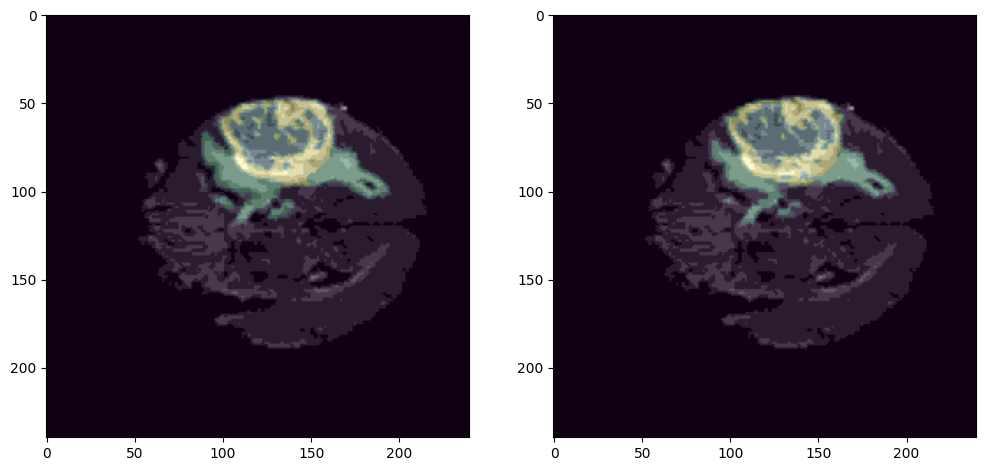

In [156]:
example_index = 12
slice_index = 54

# Get Flair Image
input_flair_image = X_test[example_index, :, :, slice_index, 2]  # FLAIR image
input_flair_image = input_flair_image.astype(np.uint8)
resized_input_flair_image = cv2.resize(input_flair_image, (240, 240))

resized_predicted_mask = cv2.resize(resized_masks[example_index, :, :, slice_index].astype(np.uint8), (240, 240))

resized_ground_truth_mask = cv2.resize(np.argmax(y_test[example_index, :, :, slice_index], axis=-1).astype(np.uint8),
                                       (240, 240))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(resized_input_flair_image, cmap='gray')
axes[0].imshow(resized_predicted_mask, alpha=0.25, cmap='viridis')


axes[1].imshow(resized_input_flair_image, cmap='gray')
axes[1].imshow(resized_ground_truth_mask, alpha=0.25, cmap='viridis')

plt.savefig('Overlay')
plt.show()

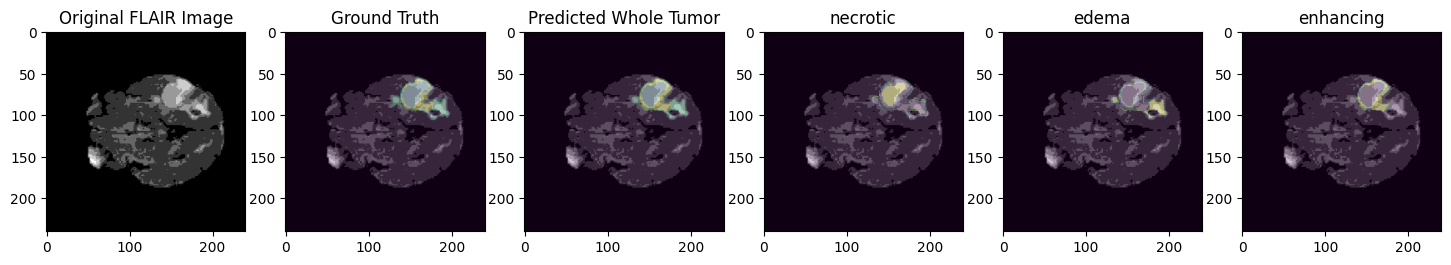

In [172]:
def visualize_overlay(example_index, slice_index):

    # Get Flair image
    flair_image = test_generator.X[example_index, :, :, slice_index, 2] 
    flair_image = flair_image.astype(np.uint8)
    resized_flair_image = cv2.resize(flair_image, (240, 240))

    resized_predicted_mask = cv2.resize(resized_masks[example_index, :, :, slice_index].astype(np.uint8),
                                       (240, 240))

    ground_truth_mask = cv2.resize(np.argmax(test_generator.y[example_index, :, :, slice_index], axis=-1).astype(np.uint8),
                                   (240, 240))

    # Get each class segmentation
    class_masks = [np.zeros_like(resized_predicted_mask) for _ in range(len(class_names) - 1)]
    for class_index in range(1, len(class_names)):
        class_mask = np.where(resized_predicted_mask == class_index, 1, 0)
        class_masks[class_index - 1] = cv2.resize(class_mask, (240, 240))

   
    fig, axes = plt.subplots(1, len(class_names) + 2, figsize=(18, 6))

    axes[0].imshow(resized_flair_image, cmap='gray')
    axes[0].set_title("Original FLAIR Image")

    axes[1].imshow(resized_flair_image, cmap='gray')
    axes[1].imshow(ground_truth_mask, alpha=0.25, cmap='viridis')
    axes[1].set_title("Ground Truth")

    axes[2].imshow(resized_flair_image, cmap='gray')
    axes[2].imshow(resized_predicted_mask, alpha=0.25, cmap='viridis')
    axes[2].set_title("Predicted Whole Tumor")

    for class_index, class_name in enumerate(class_names[1:]): 
        axes[class_index + 3].imshow(resized_flair_image, cmap='gray')
        axes[class_index + 3].imshow(class_masks[class_index], alpha=0.25, cmap='viridis')
        axes[class_index + 3].set_title(f"{class_name}")

    plt.savefig('all classes')

    plt.show()

class_names = ['not tumor', 'necrotic', 'edema', 'enhancing']
visualize_overlay(example_index=9, slice_index=56)

# Glioblastoma Growth Model

In [88]:
test_file = Training_path + 'UPENN-GBM-Training-005/seg_brain_extracted.nii'

## Credit - Simulation and modeling of natural processes; Coursera 

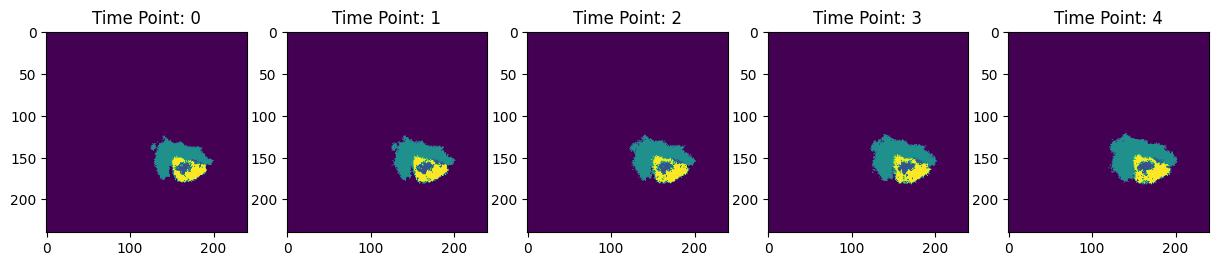

In [89]:

def simulate_glioblastoma_growth(segmentation_file, num_time_points):
   
    segmentation_data = nib.load(segmentation_file).get_fdata()

    
    background_label = 0
    time_interval = 1   
    diffusion_rate = 0.001  
    proliferation_rate = 0.005  

    
    fig, axs = plt.subplots(1, num_time_points, figsize=(15, 5))

    for t in range(num_time_points):
        for label in np.unique(segmentation_data):
            if label == background_label:
                continue

            
            label_pixels = np.argwhere(segmentation_data == label)

            # Apply diffusion to tumor boundaries
            label_pixels_diffused = diffuse_tumor(label_pixels, segmentation_data, diffusion_rate)

            # Apply proliferation 
            label_pixels_proliferated = proliferate_tumor(label_pixels, segmentation_data, proliferation_rate)

            # Update 
            segmentation_data[tuple(label_pixels_diffused.T)] = label
            segmentation_data[tuple(label_pixels_proliferated.T)] = label

        
        slice_index = segmentation_data.shape[2] // 2
        current_slice = segmentation_data[:, :, slice_index]

        
        axs[t].imshow(current_slice, cmap='viridis', vmin=0, vmax=np.max(segmentation_data))
        axs[t].set_title(f'Time Point: {t* time_interval}')

    plt.show()

def diffuse_tumor(label_pixels, segmentation_data, diffusion_rate):
    # Simulate diffusion by applying a Gaussian filter
    label_pixels_diffused = label_pixels + np.random.normal(scale=diffusion_rate, size=label_pixels.shape)

    label_pixels_diffused = np.clip(label_pixels_diffused, 0, np.array(segmentation_data.shape) - 1)

    return label_pixels_diffused.astype(int)

def proliferate_tumor(label_pixels, segmentation_data, proliferation_rate):
    # Simulate cell proliferation 
    proliferation_shifts = np.random.choice([-1, 0, 1], size=label_pixels.shape)
    label_pixels_proliferated = np.clip(label_pixels + proliferation_shifts, 0, np.array(segmentation_data.shape) - 1)

    return label_pixels_proliferated.astype(int)


segmentation_file = test_file  
num_time_points = 5
simulate_glioblastoma_growth(segmentation_file, num_time_points)